In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [24]:
# Load data
features = pd.read_csv("../src/features/macro_features.csv", parse_dates=["Date"])
features.set_index("Date", inplace=True)
# Basic Data Overview
print("Dataset Shape:", features.shape, " Columns", features.columns)

Dataset Shape: (267, 89)  Columns Index(['EU_CPI', 'EU_10Y_Yield', 'ECB_Deposit_Rate', 'US_CPI', 'US_Core_CPI',
       'Fed_Funds_Rate', 'US_10Y_Yield', 'VIX', 'EU_CPI_lag_1', 'EU_CPI_lag_2',
       'EU_CPI_lag_3', 'US_CPI_lag_1', 'US_CPI_lag_2', 'US_CPI_lag_3',
       'US_Core_CPI_lag_1', 'US_Core_CPI_lag_2', 'US_Core_CPI_lag_3',
       'EU_10Y_Yield_lag_1', 'EU_10Y_Yield_lag_2', 'EU_10Y_Yield_lag_3',
       'US_10Y_Yield_lag_1', 'US_10Y_Yield_lag_2', 'US_10Y_Yield_lag_3',
       'Fed_Funds_Rate_lag_1', 'Fed_Funds_Rate_lag_2', 'Fed_Funds_Rate_lag_3',
       'ECB_Deposit_Rate_lag_1', 'ECB_Deposit_Rate_lag_2',
       'ECB_Deposit_Rate_lag_3', 'VIX_lag_1', 'VIX_lag_2', 'VIX_lag_3',
       'EU_CPI_roc_1', 'EU_CPI_roc_2', 'EU_CPI_roc_3', 'US_CPI_roc_1',
       'US_CPI_roc_2', 'US_CPI_roc_3', 'US_Core_CPI_roc_1',
       'US_Core_CPI_roc_2', 'US_Core_CPI_roc_3', 'EU_10Y_Yield_roc_1',
       'EU_10Y_Yield_roc_2', 'EU_10Y_Yield_roc_3', 'US_10Y_Yield_roc_1',
       'US_10Y_Yield_roc_2', 'US_10Y

In [5]:
# Load close price data
price = pd.read_csv("../src/data_fetch/EURUSD.csv", parse_dates=["Date"])
price.set_index("Date", inplace=True)
price = price["EURUSD_Close"]
# Basic Data Overview
print("Dataset Shape:", price.shape)
print(price.tail)

Dataset Shape: (303,)
<bound method NDFrame.tail of Date
2000-01-31    0.97000
2000-02-29    0.96460
2000-03-31    0.95510
2000-04-30    0.91140
2000-05-31    0.93680
               ...   
2024-11-30    1.05748
2024-12-31    1.03526
2025-01-31    1.03602
2025-02-28    1.03747
2025-03-31    1.08532
Name: EURUSD_Close, Length: 303, dtype: float64>


In [6]:
price_return = price.pct_change()
print(price_return.tail)

<bound method NDFrame.tail of Date
2000-01-31         NaN
2000-02-29   -0.005567
2000-03-31   -0.009849
2000-04-30   -0.045754
2000-05-31    0.027869
                ...   
2024-11-30   -0.028400
2024-12-31   -0.021012
2025-01-31    0.000734
2025-02-28    0.001400
2025-03-31    0.046122
Name: EURUSD_Close, Length: 303, dtype: float64>


In [7]:
price_return.describe()

count    302.000000
mean       0.000739
std        0.027124
min       -0.098301
25%       -0.014849
50%        0.000158
75%        0.017112
max        0.103177
Name: EURUSD_Close, dtype: float64

In [17]:
price_return.loc[price_return > 0].describe()

count    153.000000
mean       0.020813
std        0.017985
min        0.000073
25%        0.007451
50%        0.016792
75%        0.027869
max        0.103177
Name: EURUSD_Close, dtype: float64

In [18]:
price_return.loc[price_return < 0].describe()

count    149.000000
mean      -0.019873
std        0.017883
min       -0.098301
25%       -0.025967
50%       -0.015263
75%       -0.007159
max       -0.000432
Name: EURUSD_Close, dtype: float64

In [19]:
labels = price_return.apply(lambda x: 1 if x > 0 else 0)

In [20]:
labels

Date
2000-01-31    0
2000-02-29    0
2000-03-31    0
2000-04-30    0
2000-05-31    1
             ..
2024-11-30    0
2024-12-31    0
2025-01-31    1
2025-02-28    1
2025-03-31    1
Name: EURUSD_Close, Length: 303, dtype: int64

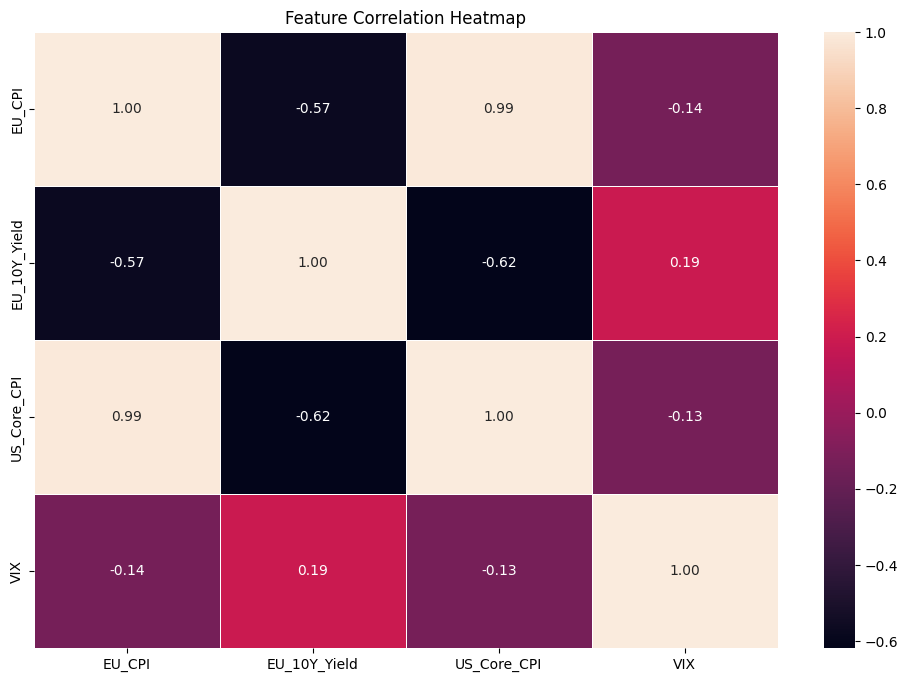

In [38]:
# Correlation Analysis
plt.figure(figsize=(12, 8))
corr_matrix = features[["EU_CPI", "EU_10Y_Yield", "US_Core_CPI", "VIX"]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()